In [2]:
from __future__ import division
import numpy as np
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10,6)
matplotlib.rcParams.update({'font.size': 24})
import matplotlib.pyplot as plt
from scipy.signal import butter, sosfiltfilt, welch, tukey

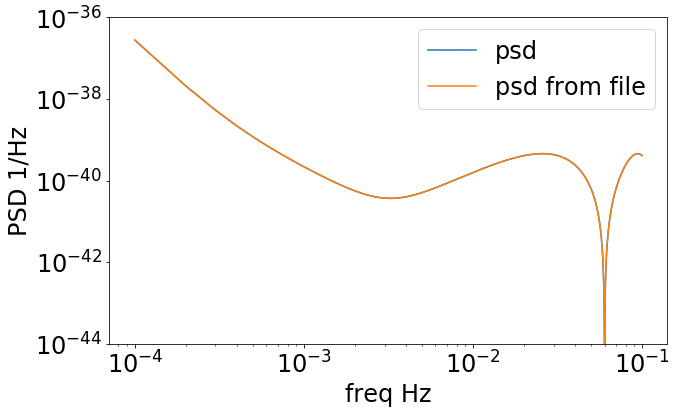

In [3]:
def psd_noise(freqs, plot=0):
    
    data = np.loadtxt('lisa_psd.txt')
    f_req, psd_req = data[:, 0], data[:, 1]
    
    psd = np.interp(freqs, f_req, np.log10(psd_req))
    psd = 10**psd
    
    
    if plot:
        plt.loglog(freqs, psd, label='psd')
        plt.loglog(f_req, psd_req, label='psd from file')
        plt.legend()
        plt.xlabel('freq Hz')
        plt.ylim([1e-44, 1e-36])
        plt.ylabel('PSD 1/Hz')
    else:
        return psd
    
## --------------------------------
psd_noise(freqs=np.arange(1e-4, 1e-1, 1e-4), plot=1)

The noise correlation is defined as (Eq 5.107 Bendot & Piersol)

$T_n = \frac{2}{R_{xx}(0)}\int_0^{\infty} d \tau | R_{xx}(\tau)|$  

We can calculate the time-domain auto-correlation function $R_{xx}$ using the real-ifft of the one-sided PSD $G_{xx}(f)$ (Eq 5.35 Bendot & Piersol)

$R_{xx} (\tau) = \int_0^{\infty} df G_{xx}(f) \cos(2\pi f \tau) $

In [6]:
def noi_corr_dur(fs=0.25, dur=1e6, **kwargs):
    
    # Number of data points in the time series
    N = int(fs*dur)
    
    # We will make an array of the desired frequencies
    fout = np.fft.rfftfreq(N, 1.0/fs)
    
    Sh = psd_noise(fout, plot=0)
    
    
    if len(kwargs) > 0:
        fmin = float(kwargs['fmin'])
        fmax = float(kwargs['fmax'])
    
        Sh[fout < fmin] = 0
        Sh[fout > fmax] = 0
        
    
    Rxx = np.fft.irfft(Sh)
    
    Rxx_0 = Rxx[0]
    
    tau_vals = np.arange(N)/fs
    dtau = tau_vals[1] - tau_vals[0]
    
    Tn = 2*np.trapz(np.abs(Rxx), x = tau_vals)/Rxx_0
    
    print('The noise correlation duration is ' + str(Tn))
    
    
        
    plt.loglog(tau_vals[0:int(0.5*tau_vals.size)], np.abs(Rxx[0:int(0.5*tau_vals.size)])/Rxx_0, linewidth=1)
    plt.xlabel('$\\tau$ in s')
    plt.axvline(1e4, color='r', linewidth=1)
    plt.ylabel('$\\dfrac{|R_{xx}( \\tau )| }{ R_{xx}(0)}$')
    plt.savefig('auto_corr.pdf', dpi=150, bbox_inches='tight')

The noise correlation duration is 5773.639217182726


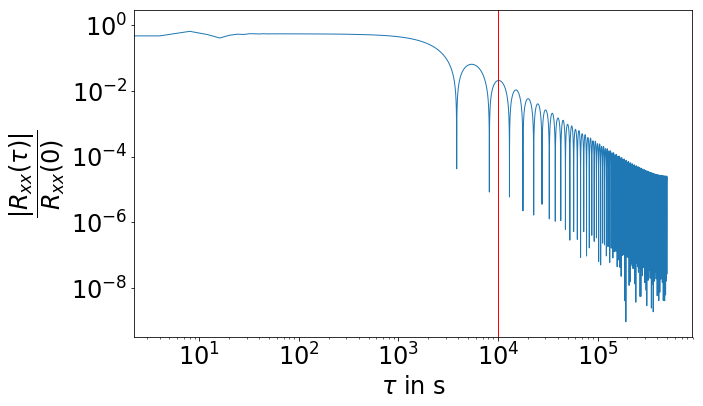

In [7]:
noi_corr_dur(fs=0.25, dur=1e6)

The noise correlation duration is 8655.108993760477


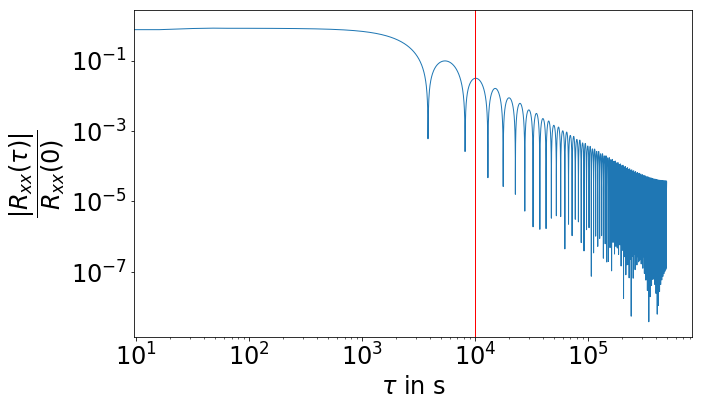

In [8]:
noi_corr_dur(fs=0.0625, dur=1e6)

The noise correlation duration is 51245.958471855105


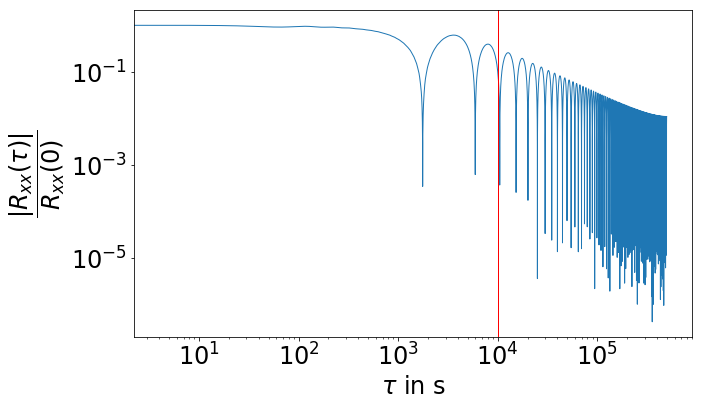

In [9]:
noi_corr_dur(fs=0.25, dur=1e6, fmin=1e-4, fmax=1e-2)

The noise correlation duration is 3683.51391534363


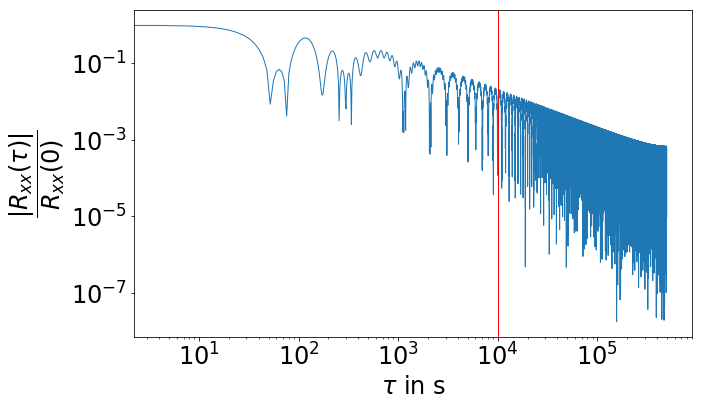

In [34]:
noi_corr_dur(fs=0.25, dur=1e6, fmin=5e-4, fmax=1e-2)

The noise correlation duration is 192.16043255838036


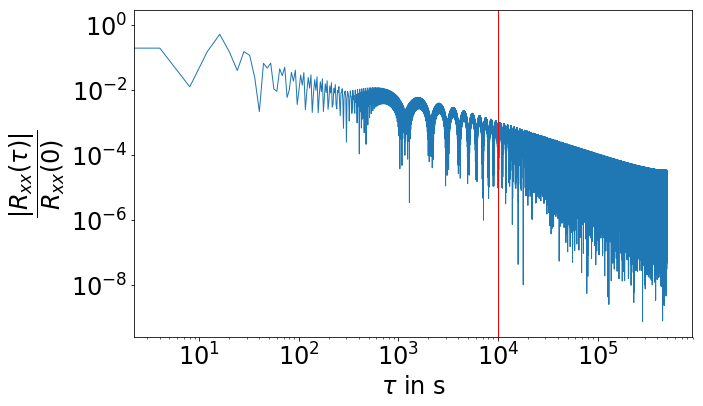

In [26]:
noi_corr_dur(fs=0.25, dur=1e6, fmin=5e-4, fmax=1e-1)

The noise correlation duration is 386.3540338598621


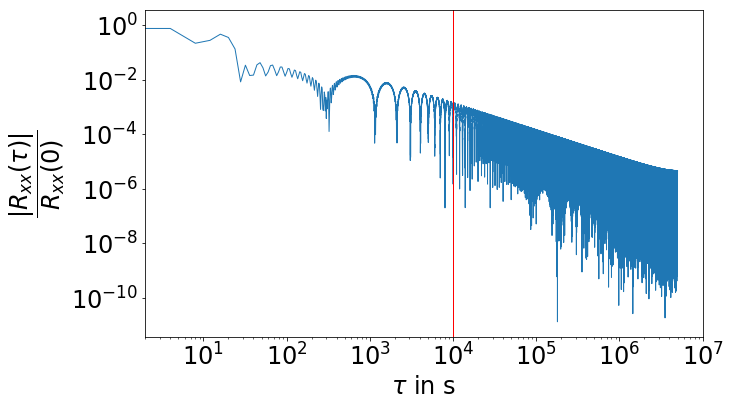

In [33]:
noi_corr_dur(fs=0.25, dur=1e7, fmin=5e-4, fmax=5e-2)